In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

In [4]:
# notebooks/example_notebook.ipynb
import sys
import os
sys.path.append(os.path.abspath('../scripts'))

In [12]:
from load_data import load_data_from_postgres, load_data_using_sqlalchemy
from sql_queries import execute_telecom_queries

In [13]:
# Load environment variables from .env file
load_dotenv()
# Fetch database connection parameters from environment variables
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

In [14]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"

# Load data from PostgreSQL using SQLAlchemy
df = load_data_using_sqlalchemy(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

Successfully loaded the data


In [17]:
# Replace missing values
for col in ['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 'Handset Type']:
    if df[col].dtype == 'object':
        # Replace NaN with mode for categorical columns
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        # Replace NaN with mean for numeric columns
        df[col] = df[col].fillna(df[col].mean())

# Aggregate per customer
aggregated_experience = df.groupby('MSISDN/Number').agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'TCP UL Retrans. Vol (Bytes)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Avg RTT UL (ms)': 'mean',
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean',
    'Handset Type': lambda x: x.mode().iloc[0]  # Handle mode safely
}).reset_index()

# Rename columns for clarity
aggregated_experience.rename(columns={
    'TCP DL Retrans. Vol (Bytes)': 'Avg TCP DL Retransmission',
    'TCP UL Retrans. Vol (Bytes)': 'Avg TCP UL Retransmission',
    'Avg RTT DL (ms)': 'Avg RTT DL',
    'Avg RTT UL (ms)': 'Avg RTT UL',
    'Avg Bearer TP DL (kbps)': 'Avg Throughput DL',
    'Avg Bearer TP UL (kbps)': 'Avg Throughput UL'
}, inplace=True)


## Aggregate Metrics

In [20]:
# Step 1: Aggregate Metrics
aggregated_metrics = df.groupby('MSISDN/Number').agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'TCP UL Retrans. Vol (Bytes)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Avg RTT UL (ms)': 'mean',
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean',
    'Handset Type': 'first'  # Assuming a single handset type per user
}).reset_index()

# Rename columns for clarity
aggregated_metrics.rename(columns={
    'TCP DL Retrans. Vol (Bytes)': 'Avg TCP DL Retransmission',
    'TCP UL Retrans. Vol (Bytes)': 'Avg TCP UL Retransmission',
    'Avg RTT DL (ms)': 'Avg RTT DL',
    'Avg RTT UL (ms)': 'Avg RTT UL',
    'Avg Bearer TP DL (kbps)': 'Avg Throughput DL',
    'Avg Bearer TP UL (kbps)': 'Avg Throughput UL'
}, inplace=True)

# Display results
print("Aggregated Metrics per User:\n", aggregated_metrics.head())


Aggregated Metrics per User:
    MSISDN/Number  Avg TCP DL Retransmission  Avg TCP UL Retransmission  \
0   3.360100e+10               2.080991e+07              759658.664811   
1   3.360100e+10               2.080991e+07              759658.664811   
2   3.360100e+10               2.080991e+07              759658.664811   
3   3.360101e+10               1.066000e+03              759658.664811   
4   3.360101e+10               1.507977e+07              390430.332406   

   Avg RTT DL  Avg RTT UL  Avg Throughput DL  Avg Throughput UL  \
0   46.000000    0.000000               37.0               39.0   
1   30.000000    1.000000               48.0               51.0   
2  109.795706   17.662883               48.0               49.0   
3   69.000000   15.000000              204.0               44.0   
4   57.000000    2.500000            20197.5             8224.5   

                     Handset Type  
0  Huawei P20 Lite Huawei Nova 3E  
1          Apple iPhone 7 (A1778)  
2             

## Top and Bottom Values

In [22]:
# Step 2: Top and Bottom Values
metrics = ['Avg TCP DL Retransmission', 'Avg TCP UL Retransmission', 'Avg RTT DL', 'Avg RTT UL', 'Avg Throughput DL', 'Avg Throughput UL']

for metric in metrics:
    print(f"\nTop 10 {metric}:\n", aggregated_metrics.nlargest(10, metric))
    print(f"\nBottom 10 {metric}:\n", aggregated_metrics.nsmallest(10, metric))
    print(f"\nMost Frequent {metric}:\n", aggregated_metrics[metric].value_counts().nlargest(10))



Top 10 Avg TCP DL Retransmission:
        MSISDN/Number  Avg TCP DL Retransmission  Avg TCP UL Retransmission  \
85785   3.369858e+10               4.289488e+09                 11989838.0   
32273   3.365871e+10               4.288060e+09                    60496.0   
58026   3.366491e+10               4.268432e+09                   215354.0   
31942   3.365863e+10               4.254644e+09                    15816.0   
62049   3.366613e+10               4.211189e+09                    68802.0   
70079   3.366877e+10               4.166591e+09                     3989.0   
43629   3.366131e+10               4.131046e+09                  6891979.0   
48341   3.366240e+10               4.117753e+09                    51555.0   
64113   3.366682e+10               3.968072e+09                    48174.0   
98211   3.376264e+10               3.785295e+09                  1576179.0   

       Avg RTT DL  Avg RTT UL  Avg Throughput DL  Avg Throughput UL  \
85785       244.0       242.0     

## Analysis by Handset

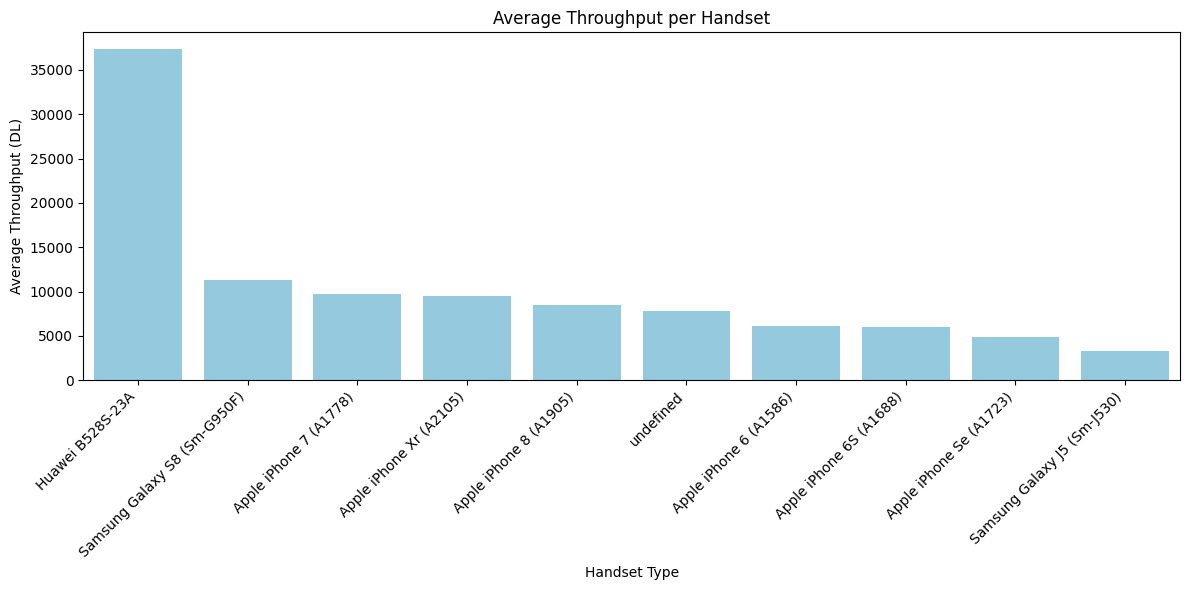

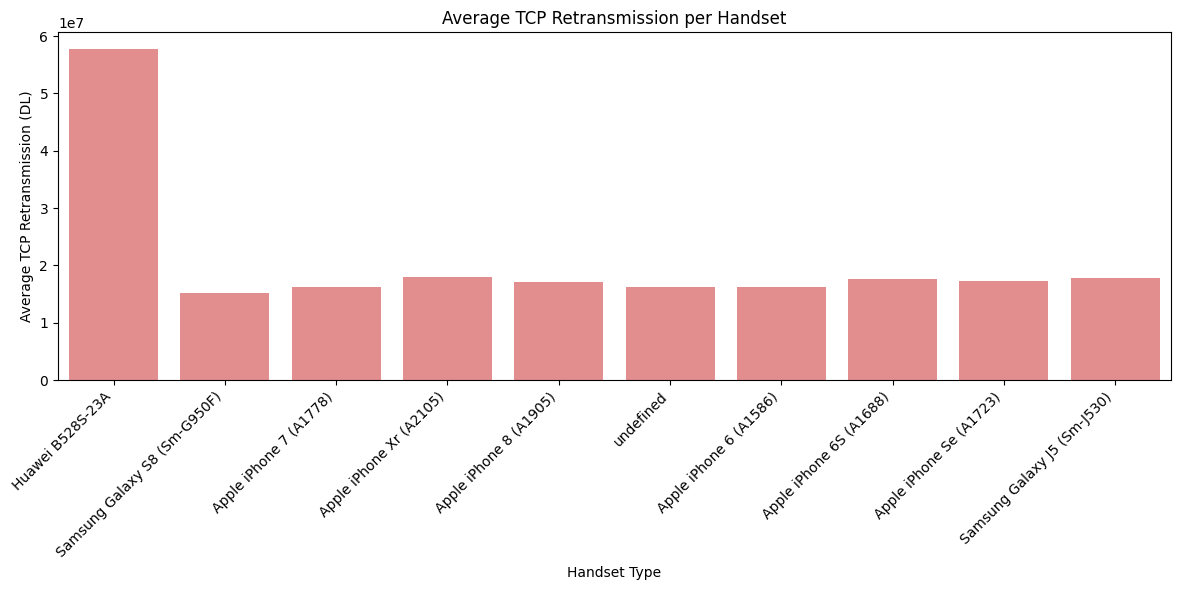

In [30]:
# Analysis by Handset
handset_analysis = aggregated_metrics.groupby('Handset Type').agg({
    'Avg TCP DL Retransmission': 'mean',
    'Avg RTT DL': 'mean',
    'Avg Throughput DL': 'mean'
}).reset_index()

# Filter for top 10 handsets by frequency
top_handsets = aggregated_metrics['Handset Type'].value_counts().nlargest(10).index
handset_analysis = handset_analysis[handset_analysis['Handset Type'].isin(top_handsets)]

# Sort data for better visualization
handset_analysis = handset_analysis.sort_values(by='Avg Throughput DL', ascending=False)

# Plot Average Throughput per Handset
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Handset Type', 
    y='Avg Throughput DL', 
    data=handset_analysis, 
    color='skyblue'  # Using a single color to avoid FutureWarning
)
plt.title("Average Throughput per Handset")
plt.xlabel("Handset Type")
plt.ylabel("Average Throughput (DL)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot Average TCP Retransmission per Handset
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Handset Type', 
    y='Avg TCP DL Retransmission', 
    data=handset_analysis, 
    color='lightcoral'  # Using a single color to avoid FutureWarning
)
plt.title("Average TCP Retransmission per Handset")
plt.xlabel("Handset Type")
plt.ylabel("Average TCP Retransmission (DL)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Experience Clustering

Cluster Summary:
   Cluster Avg TCP DL Retransmission                Avg RTT DL              \
                               mean           std        mean         std   
0       0              7.547280e+07  3.643860e+08   68.198253   87.477120   
1       1              1.702167e+07  1.643699e+07  128.753841  663.753613   
2       2              1.716309e+07  1.053951e+08   90.798795  162.862111   

  Avg Throughput DL                
               mean           std  
0      75788.913818  23969.663138  
1       1908.707988   3972.231274  
2      31086.944537  10118.711404  


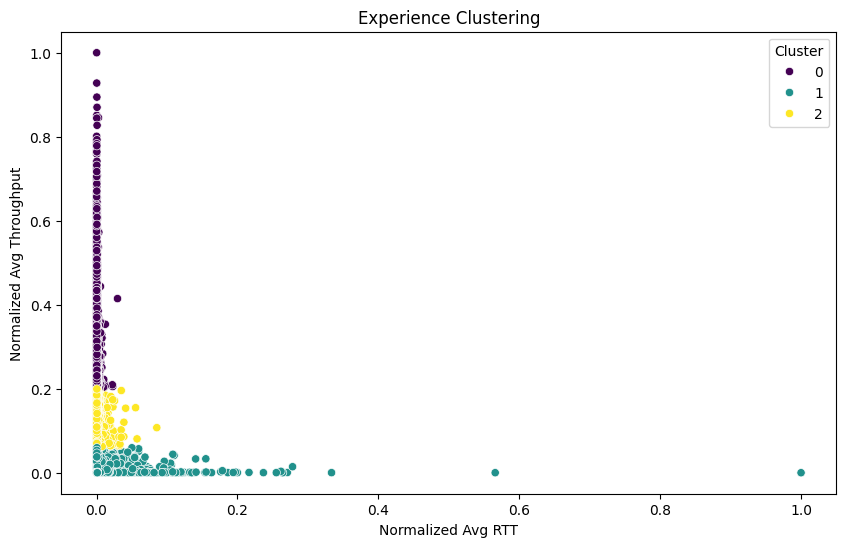

In [27]:
# Normalize data for clustering
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(
    aggregated_metrics[['Avg TCP DL Retransmission', 'Avg RTT DL', 'Avg Throughput DL']]
)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
aggregated_metrics['Cluster'] = kmeans.fit_predict(normalized_metrics)

# Analyze Clusters
cluster_summary = aggregated_metrics.groupby('Cluster').agg({
    'Avg TCP DL Retransmission': ['mean', 'std'],
    'Avg RTT DL': ['mean', 'std'],
    'Avg Throughput DL': ['mean', 'std']
}).reset_index()

print("Cluster Summary:\n", cluster_summary)

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=normalized_metrics[:, 1],  # Avg RTT
    y=normalized_metrics[:, 2],  # Avg Throughput
    hue=aggregated_metrics['Cluster'],
    palette='viridis'
)
plt.title("Experience Clustering")
plt.xlabel("Normalized Avg RTT")
plt.ylabel("Normalized Avg Throughput")
plt.legend(title="Cluster")
plt.show()
